In [105]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plot

In [106]:
IMG_PATH = ['images/TS-027.png', 'images/TS-030.png', 'images/TS-028.png', 'images/TS-029.png', 'images/TS-031.png', 'images/TS-032.png', 'images/TS-033.png', 'images/TS-034.png', 'images/TS-035.png', 'images/TS-036.png', 'images/TS-037.png', 'images/TS-038.png', 'images/TS-039.png', 'images/TS-040.png', 'images/TS-041.png', 'images/TS-042.png', 'images/TS-043.png', 'images/TS-044.png', 'images/TS-045.png', 'images/TS-046.png']
METHOD = 'SIFT'
RATIO = 0.4
RANSAC_THRESHOLD = 3.5

In [107]:
def load_images(img_paths):
    images = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [108]:
def view_images(images):
    # Now view/plot the images
    n = len(images)
    cols = 2
    rows = (n // cols) + (n % cols > 0)
    plot.figure(figsize=(16, 9))
    for i in range(n):
        plot.subplot(rows, cols, i + 1)
        plot.imshow(images[i])
        plot.axis('off')
        plot.title("Image " + str(i+1))
    plot.show()

In [109]:
def get_keypoints(img1, img2):
    
    descriptor = cv2.SIFT_create()
    kp1, desc1 = descriptor.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), None)
    kp2, desc2 = descriptor.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), None)

    # display the keypoints and features detected on both images
    # fig, (ax1, ax2) = plot.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    # ax1.imshow(cv2.drawKeypoints(img1, kp1, None, color=(0,255,0)))
    # ax1.set_title("Source image keypoints")
    # ax1.axis('off')
    
    # ax2.imshow(cv2.drawKeypoints(img2, kp2, None, color=(0,255,0)))
    # ax2.set_title("Stitching image keypoints")
    # ax2.axis('off')
    
    # plot.show()

    return kp1, kp2, desc1, desc2

In [110]:
def get_matches(img1, img2, kp1, kp2, desc1, desc2):
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(desc2, desc1, k=2)

    # ratio test
    good = []
    for m in matches:
        if m[0].distance < m[1].distance * RATIO:
            good.append(m[0])

    # fig =  plot.figure(figsize=(20,8))
    # mapped_features_image = cv2.drawMatches(img1, kp1, img2, kp2, good[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plot.axis('off')
    # plot.title("Brute force matches")
    # plot.imshow(mapped_features_image)

    return good

In [111]:
def get_homography_matrix(matches, kp1, kp2):
    if len(matches) < 4:
        raise ValueError("Not enough keypoints")
    else:
        pts1 = np.float32([kp1[m.trainIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.queryIdx].pt for m in matches])
        
        H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC, RANSAC_THRESHOLD)
        return H

In [112]:
def get_transformed_corners(image, H):
    h, w = image.shape[:2]
    corners = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype='float32')
    corners = np.array([corners])
    transformed_corners = cv2.perspectiveTransform(corners, H)
    return transformed_corners

In [113]:
def stitch_images(img1, img2, H):
    transformed_corners = get_transformed_corners(img2, H)
    
    x_min = min(transformed_corners[0,:,0])
    x_max = max(transformed_corners[0,:,0])
    y_min = min(transformed_corners[0,:,1])
    y_max = max(transformed_corners[0,:,1])
    
    width = int(max(img1.shape[1], x_max) - min(0, x_min))
    height = int(max(img1.shape[0], y_max) - min(0, y_min))
    
    x_offset = int(-min(0, x_min))
    y_offset = int(-min(0, y_min))
    
    translation_matrix = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]])
    adjusted_H = np.dot(translation_matrix, H)
    
    result = cv2.warpPerspective(img2, adjusted_H, (width, height))

    # remove empty pixels
    mask = (img1 != [0, 0, 0]).all(axis=2)
    
    result[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]][mask] = img1[mask]

    return result

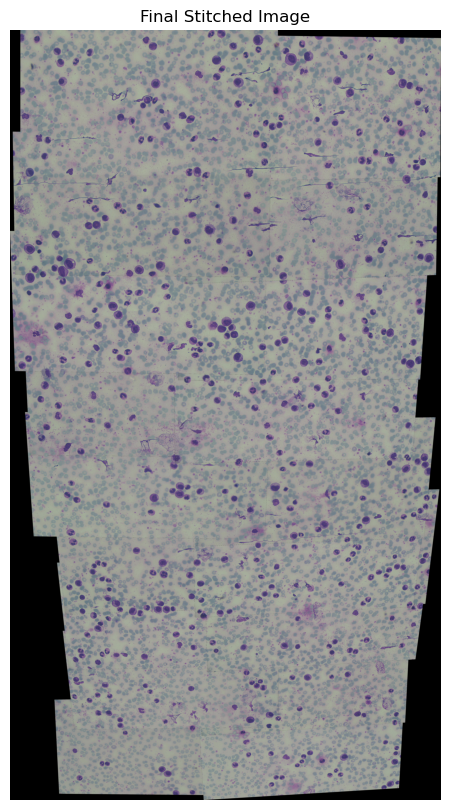

In [114]:
# load images
images = load_images(IMG_PATH)

# Now view/plot the images
# view_images(images)

stitched_img = images[0]
for i in range(1, len(images)):
    # getting SIFT keypoints and descriptors
    kp1, kp2, desc1, desc2 = get_keypoints(stitched_img, images[i])
    
    # finding matches using brute force method
    matches = get_matches(stitched_img, images[i], kp1, kp2, desc1, desc2)

    # finding homography matrix
    H = get_homography_matrix(matches, kp1, kp2)
    
    # stitching image
    stitched_img = stitch_images(stitched_img, images[i], H)
    imageio.imwrite("./stitched-img-" + str(i) + ".png", stitched_img)

plot.figure(figsize=(20,10))
plot.axis('off')
plot.imshow(stitched_img)
plot.title("Final Stitched Image")
plot.show()

## GROUND TRUTH FOR REFERENCE

![Image Description](gt.png)
